<a href="https://colab.research.google.com/github/khamies/Piano-VAE/blob/master/play_with_model.ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download data and files.
!git clone https://github.com/Khamies/Piano-VAE.git
import os 
os.chdir("Piano-VAE")

Cloning into 'Piano-VAE'...
remote: Enumerating objects: 1192, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 1192 (delta 41), reused 96 (delta 40), pack-reused 1074 (from 1)
Receiving objects: 100% (1192/1192), 17.22 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [1]:
import os
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch
import numpy as np
# from google.colab import files
from model import LSTM_MUSIC_VAE
from dataset import PianoGenerationDataset
from utils.utils import interpolate

In [4]:
from utils.midi.midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt

In [16]:
# Settings

torch.manual_seed(1000)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
batch_size = 32
bptt = 60
lr = 0.001

embed_size = 300
hidden_size = 256
latent_size = 16
lstm_layer=1
notes_size = 88 #unique piano notes

Using device: cuda


## Load the data

In [17]:
trainset = PianoGenerationDataset('./data/Nottingham/train/', longest_sequence_length=None)
testset = PianoGenerationDataset('./data/Nottingham/test/', longest_sequence_length=None)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, drop_last=True)

## Load the model

In [18]:
vocab_size = notes_size
model = LSTM_MUSIC_VAE(vocab_size = vocab_size, embed_size = embed_size, hidden_size = hidden_size, latent_size = latent_size).to(device)


checkpoint = torch.load("models/LSTM_Music_VAE.pt")
model.load_state_dict(checkpoint["model"])

/tmp/ipykernel_163791/461827592.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/LSTM_Music_VAE.pt")


<All keys matched successfully>

# play and display midi

In [24]:
import os
from glob import glob
import random
import numpy as np
import mido
import pretty_midi
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Define constants directly (since we can't import from dataloaders)
SLICE_SECONDS = 8.0
QPM = 120  # beats per minute
STEPS_PER_QUARTER = 16
PITCH_RANGE_START = 21  # A0
INPUT_DIM = 88  # piano keys
SEQUENCE_LENGTH = 200

def plot_pianoroll(roll, title="Pianoroll", figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(roll.T, aspect='auto', origin='lower', interpolation='nearest', cmap='Blues')
    plt.xlabel(f'Time step ({SEQUENCE_LENGTH} steps = {SLICE_SECONDS} sec)')
    plt.ylabel('Pitch (A0..C8)')
    plt.title(title)
    plt.colorbar(label='Note On/Off')
    plt.tight_layout()
    plt.show()

def midi_to_audio_array(midi_path, sr=22050, soundfont_path=None):
    """Convert MIDI file to audio array"""
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        # Use built-in synthesizer
        audio = pm.synthesize(fs=sr)
        return audio, sr
    except Exception as e:
        print(f"Error loading MIDI: {e}")
        # Return silence if MIDI loading fails
        return np.zeros(int(sr * SLICE_SECONDS)), sr

def roll_to_notes(roll, qpm=QPM, steps_per_quarter=STEPS_PER_QUARTER):
    """
    Convert (T,F) binary roll to list of {'pitch','start','end'} in seconds.
    """
    seconds_per_step = 60.0 / (qpm * steps_per_quarter)
    T, F = roll.shape
    notes = []
    for f in range(F):
        active = False
        start_t = 0
        for t in range(T):
            on = roll[t, f] >= 0.5
            if on and not active:
                active = True
                start_t = t
            elif not on and active:
                active = False
                end_t = t
                notes.append({
                    'pitch': f + PITCH_RANGE_START,
                    'start': start_t * seconds_per_step,
                    'end': end_t * seconds_per_step,
                    'velocity': 80
                })
        if active:
            notes.append({
                'pitch': f + PITCH_RANGE_START,
                'start': start_t * seconds_per_step,
                'end': SLICE_SECONDS,
                'velocity': 80
            })
    return notes

def notes_to_midi(notes, out_path, qpm=QPM):
    """Write notes to MIDI file"""
    # Create a PrettyMIDI object
    pm = pretty_midi.PrettyMIDI(initial_tempo=qpm)
    
    # Create an instrument
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano
    
    # Add notes to the instrument
    for note_info in notes:
        note = pretty_midi.Note(
            velocity=note_info.get('velocity', 80),
            pitch=int(note_info['pitch']),
            start=note_info['start'],
            end=note_info['end']
        )
        instrument.notes.append(note)
    
    # Add the instrument to the PrettyMIDI object
    pm.instruments.append(instrument)
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(out_path) if os.path.dirname(out_path) else '.', exist_ok=True)
    
    # Write the MIDI file
    pm.write(out_path)
    return out_path

In [50]:
def play_and_display(pianoroll, title="Generated Piano Roll", temp_midi="temp_sample.mid"):
    """
    Display pianoroll as image and play as audio.
    
    Args:
        pianoroll: numpy array of shape (time_steps, num_pitches) with binary values
        title: title for the plot
        temp_midi: temporary filename for MIDI file
    """
    # Ensure pianoroll is 2D
    if len(pianoroll.shape) == 3:
        pianoroll = pianoroll.squeeze()
    
    # Plot the pianoroll
    plot_pianoroll(pianoroll, title=title)
    
    # Convert to MIDI and play
    try:
        # Convert pianoroll to notes
        notes = roll_to_notes(pianoroll)
        
        # Save as MIDI file
        midi_path = notes_to_midi(notes, temp_midi)
        
        # Convert MIDI to audio and play
        audio_array, sr = midi_to_audio_array(midi_path)
        
        # Display audio player
        display(Audio(audio_array, rate=sr))
        
        print(f"Generated {len(notes)} notes")
        print(f"MIDI saved as: {midi_path}")
        
    except Exception as e:
        print(f"Error in audio generation: {e}")
        print("Showing pianoroll visualization only.")

In [51]:
# Dynamic timing-aware functions
def get_pianoroll_timing(pianoroll_shape, actual_duration=None, fs=None):
    """
    Calculate timing parameters based on pianoroll shape and actual duration
    """
    time_steps, num_pitches = pianoroll_shape
    
    if actual_duration is not None:
        # Use actual MIDI duration
        duration = actual_duration
        calculated_fs = time_steps / duration
    elif fs is not None:
        # Use provided sampling frequency
        duration = time_steps / fs
        calculated_fs = fs
    else:
        # Fallback to default
        duration = SLICE_SECONDS
        calculated_fs = time_steps / duration
    
    seconds_per_step = duration / time_steps
    
    return {
        'duration': duration,
        'time_steps': time_steps,
        'fs': calculated_fs,
        'seconds_per_step': seconds_per_step
    }

def roll_to_notes_dynamic(roll, actual_duration=None, fs=None, qpm=QPM):
    """
    Convert pianoroll to notes with dynamic timing based on actual duration
    """
    timing = get_pianoroll_timing(roll.shape, actual_duration, fs)
    
    print(f"Converting pianoroll: {roll.shape} -> {timing['duration']:.2f}s (fs={timing['fs']:.1f}Hz)")
    
    T, F = roll.shape
    notes = []
    
    for f in range(F):
        active = False
        start_t = 0
        for t in range(T):
            on = roll[t, f] >= 0.5
            if on and not active:
                active = True
                start_t = t
            elif not on and active:
                active = False
                end_t = t
                notes.append({
                    'pitch': f + PITCH_RANGE_START,
                    'start': start_t * timing['seconds_per_step'],
                    'end': end_t * timing['seconds_per_step'],
                    'velocity': 80
                })
        if active:
            notes.append({
                'pitch': f + PITCH_RANGE_START,
                'start': start_t * timing['seconds_per_step'],
                'end': timing['duration'],  # Use actual duration, not hardcoded SLICE_SECONDS
                'velocity': 80
            })
    return notes, timing

def play_and_display_dynamic(pianoroll, title="Generated Piano Roll", temp_midi="temp_sample.mid", 
                           actual_duration=None, fs=None):
    """
    Display pianoroll and play audio with correct timing
    """
    # Ensure pianoroll is 2D
    if len(pianoroll.shape) == 3:
        pianoroll = pianoroll.squeeze()
    
    # Get timing information
    timing = get_pianoroll_timing(pianoroll.shape, actual_duration, fs)
    
    # Plot with correct timing
    plt.figure(figsize=(12, 6))
    plt.imshow(pianoroll.T, aspect='auto', origin='lower', interpolation='nearest', cmap='Blues')
    plt.xlabel(f'Time step ({timing["time_steps"]} steps = {timing["duration"]:.2f} sec, fs={timing["fs"]:.1f}Hz)')
    plt.ylabel('Pitch (A0..C8)')
    plt.title(title)
    plt.colorbar(label='Note On/Off')
    plt.tight_layout()
    plt.show()
    
    # Convert to MIDI and play with correct timing
    try:
        # Convert pianoroll to notes with correct timing
        notes, _ = roll_to_notes_dynamic(pianoroll, actual_duration, fs)
        
        # Save as MIDI file
        midi_path = notes_to_midi_dynamic(notes, temp_midi, timing['duration'])
        
        # Convert MIDI to audio and play
        audio_array, sr = midi_to_audio_array(midi_path)
        
        # Display audio player
        display(Audio(audio_array, rate=sr))
        
        print(f"Generated {len(notes)} notes over {timing['duration']:.2f} seconds")
        print(f"MIDI saved as: {midi_path}")
        
    except Exception as e:
        print(f"Error in audio generation: {e}")
        print("Showing pianoroll visualization only.")

def notes_to_midi_dynamic(notes, out_path, duration, qpm=QPM):
    """Write notes to MIDI file with correct duration"""
    # Create a PrettyMIDI object
    pm = pretty_midi.PrettyMIDI(initial_tempo=qpm)
    
    # Create an instrument
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano
    
    # Add notes to the instrument
    for note_info in notes:
        # Ensure note times don't exceed the actual duration
        start_time = max(0, min(duration, note_info['start']))
        end_time = max(start_time, min(duration, note_info['end']))
        
        if end_time > start_time:  # Only add valid notes
            note = pretty_midi.Note(
                velocity=note_info.get('velocity', 80),
                pitch=int(note_info['pitch']),
                start=start_time,
                end=end_time
            )
            instrument.notes.append(note)
    
    # Add the instrument to the PrettyMIDI object
    pm.instruments.append(instrument)
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(out_path) if os.path.dirname(out_path) else '.', exist_ok=True)
    
    # Write the MIDI file
    pm.write(out_path)
    return out_path

##Sample Generation

Sample shape: (50, 88)
Sample min/max: 0.000/1.000
Estimated duration: 2.00 seconds


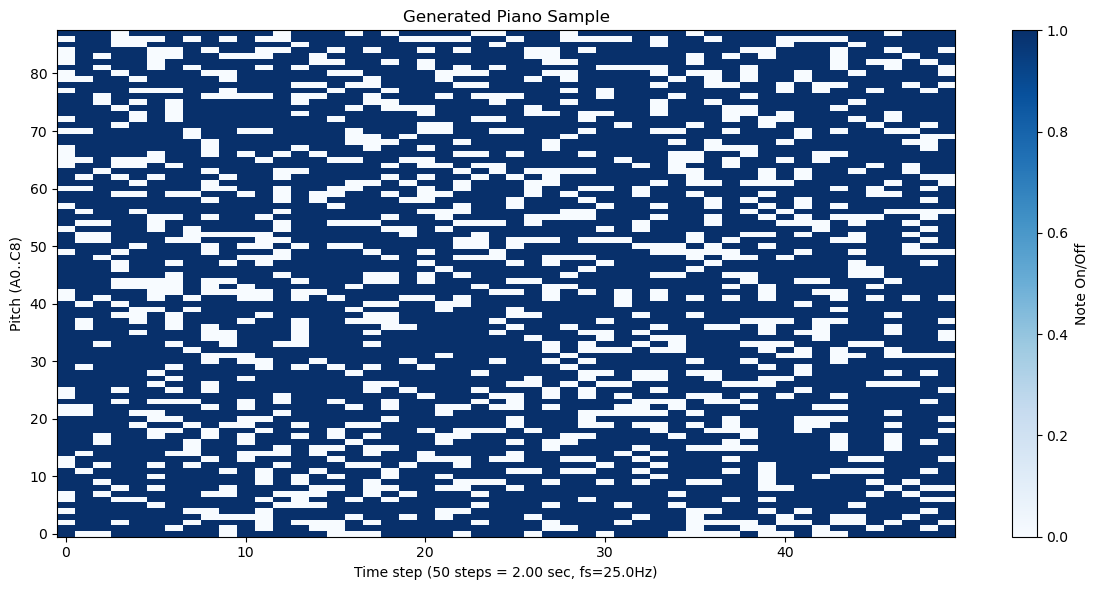

Converting pianoroll: (50, 88) -> 2.00s (fs=25.0Hz)


Generated 918 notes over 2.00 seconds
MIDI saved as: generated_sample.mid


In [60]:
# Use pitch_index to set the note value (pitch) for the initial note.

z = torch.randn(1,1,latent_size).to(device)
sample = model.inference(50,z)

# Convert sample to numpy and ensure it's in the right format
if isinstance(sample, torch.Tensor):
    sample_np = sample.detach().cpu().numpy()
else:
    sample_np = np.array(sample)

# Ensure the shape is correct for pianoroll (time_steps, num_pitches)
print(f"Sample shape: {sample_np.shape}")
print(f"Sample min/max: {sample_np.min():.3f}/{sample_np.max():.3f}")

# Save as MIDI using the original function
midiwrite("sample.midi", sample) 

# Display and play the generated sample with appropriate timing
# For generated samples, calculate duration based on typical model output
generated_duration = sample_np.shape[0] / 25.0  # Assume 25 Hz for generated samples (50 steps / 2 seconds)
print(f"Estimated duration: {generated_duration:.2f} seconds")

play_and_display_dynamic(sample_np, 
                        title="Generated Piano Sample",
                        temp_midi="generated_sample.mid",
                        actual_duration=generated_duration)

# Encode and Decode Existing MIDI File

Loading MIDI file: slice_00000.mid
Actual MIDI duration: 2.000 seconds
Error loading MIDI: 'midiread' object has no attribute 'shape'
MIDI duration: 2.000s
Target length: 200 steps
Optimal fs: 100.0 Hz
Loaded with pretty_midi - shape: (200, 88)
Active notes: 139


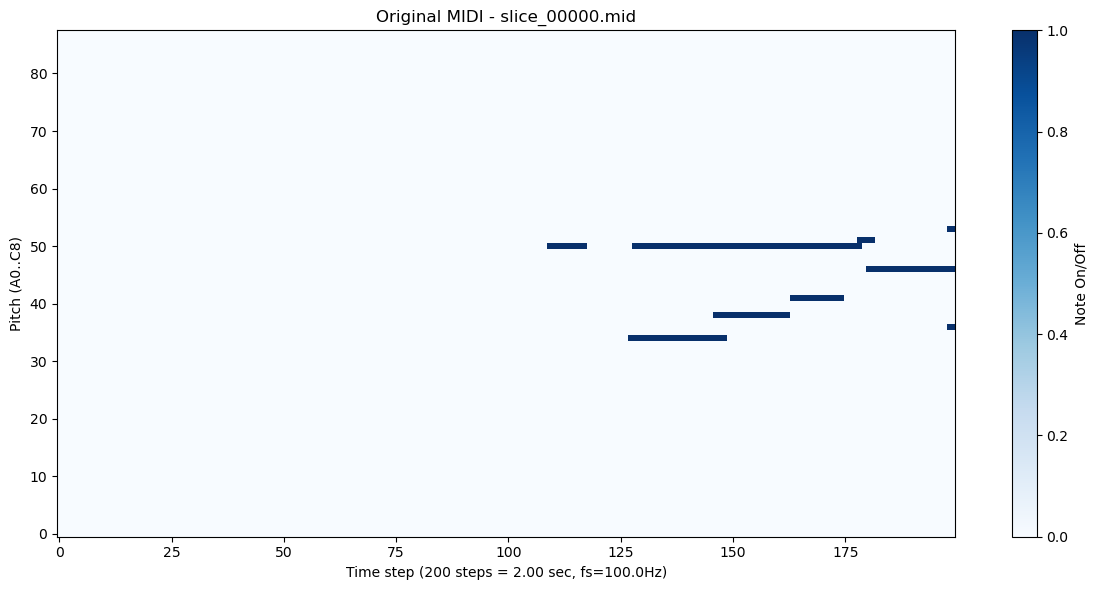

Converting pianoroll: (200, 88) -> 2.00s (fs=100.0Hz)


Generated 9 notes over 2.00 seconds
MIDI saved as: original_temp.mid


In [53]:
# Load the original MIDI file with correct timing tracking
original_midi_path = "slice_00000.mid"
print(f"Loading MIDI file: {original_midi_path}")

# First, get the actual MIDI duration for reference
pm_ref = pretty_midi.PrettyMIDI(original_midi_path)
actual_duration = pm_ref.get_end_time()
print(f"Actual MIDI duration: {actual_duration:.3f} seconds")

# Read the MIDI file using the Piano-VAE's midiread function
try:
    original_pianoroll = midiread(original_midi_path)
    print(f"Original pianoroll shape: {original_pianoroll.shape}")
    print(f"Original min/max: {original_pianoroll.min():.3f}/{original_pianoroll.max():.3f}")
    
    # Display the original pianoroll with correct timing
    play_and_display_dynamic(original_pianoroll, 
                           title="Original MIDI - slice_00000.mid", 
                           temp_midi="original_temp.mid",
                           actual_duration=actual_duration)
    
except Exception as e:
    print(f"Error loading MIDI: {e}")
    # If midiread doesn't work, try using pretty_midi with optimal fs
    try:
        pm = pretty_midi.PrettyMIDI(original_midi_path)
        
        # Calculate optimal fs for Piano-VAE (200 time steps target)
        duration = pm.get_end_time()
        target_length = 200
        optimal_fs = target_length / duration
        
        print(f"MIDI duration: {duration:.3f}s")
        print(f"Target length: {target_length} steps")
        print(f"Optimal fs: {optimal_fs:.1f} Hz")
        
        # Convert to pianoroll with optimal sampling rate
        pianoroll = pm.get_piano_roll(fs=optimal_fs)
        # Transpose and convert to binary
        pianoroll = (pianoroll > 0).astype(float).T
        
        # Crop/pad to standard piano range (88 keys)
        if pianoroll.shape[1] > 88:
            pianoroll = pianoroll[:, 21:109]  # Standard piano range A0-C8
        elif pianoroll.shape[1] < 88:
            # Pad with zeros if needed
            padding = 88 - pianoroll.shape[1]
            pianoroll = np.pad(pianoroll, ((0, 0), (0, padding)), mode='constant')
        
        # Ensure exactly 200 time steps (crop or pad as needed)
        if pianoroll.shape[0] > target_length:
            pianoroll = pianoroll[:target_length, :]
        elif pianoroll.shape[0] < target_length:
            padding = target_length - pianoroll.shape[0]
            pianoroll = np.pad(pianoroll, ((0, padding), (0, 0)), mode='constant')
        
        original_pianoroll = pianoroll
        actual_duration = duration  # Store the actual duration
        print(f"Loaded with pretty_midi - shape: {original_pianoroll.shape}")
        print(f"Active notes: {np.sum(original_pianoroll > 0.5)}")
        
        # Display with correct timing information
        play_and_display_dynamic(original_pianoroll, 
                               title="Original MIDI - slice_00000.mid", 
                               temp_midi="original_temp.mid",
                               actual_duration=actual_duration)
        
    except Exception as e2:
        print(f"Error with pretty_midi too: {e2}")
        original_pianoroll = None
        actual_duration = None

# Understanding MIDI Sampling Frequency (fs) Parameter

In [54]:
# Analyze MIDI timing to determine optimal sampling frequency
original_midi_path = "slice_00000.mid"

def analyze_midi_timing(midi_path):
    """
    Analyze MIDI file to understand timing structure and suggest optimal fs
    """
    print(f"Analyzing MIDI timing for: {midi_path}")
    print("="*60)
    
    pm = pretty_midi.PrettyMIDI(midi_path)
    
    # Basic MIDI info
    print(f"MIDI Duration: {pm.get_end_time():.3f} seconds")
    print(f"Initial Tempo: {pm.estimate_tempo():.1f} BPM")
    print(f"Number of instruments: {len(pm.instruments)}")
    
    # Analyze tempo changes
    tempo_changes = pm.get_tempo_changes()
    if len(tempo_changes[0]) > 1:
        print(f"Tempo changes found: {len(tempo_changes[0])} changes")
        for i, (time, tempo) in enumerate(zip(tempo_changes[0], tempo_changes[1])):
            print(f"  Time {time:.3f}s: {tempo:.1f} BPM")
    else:
        print(f"Constant tempo: {tempo_changes[1][0]:.1f} BPM")
    
    # Analyze note timing resolution
    all_note_times = []
    total_notes = 0
    
    for instrument in pm.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                all_note_times.extend([note.start, note.end])
                total_notes += 1
    
    print(f"Total notes: {total_notes}")
    
    if all_note_times:
        all_note_times = sorted(set(all_note_times))
        
        # Calculate minimum time differences (resolution)
        time_diffs = []
        for i in range(1, len(all_note_times)):
            diff = all_note_times[i] - all_note_times[i-1]
            if diff > 0:  # Ignore simultaneous events
                time_diffs.append(diff)
        
        if time_diffs:
            min_diff = min(time_diffs)
            mean_diff = np.mean(time_diffs)
            
            print(f"\\nTiming Analysis:")
            print(f"Minimum time difference: {min_diff:.6f}s ({1/min_diff:.1f} Hz)")
            print(f"Average time difference: {mean_diff:.6f}s ({1/mean_diff:.1f} Hz)")
            
            # Suggest sampling frequencies
            suggested_fs_min = 1 / min_diff * 2  # Nyquist criterion
            suggested_fs_practical = max(10, min(200, suggested_fs_min))
            
            print(f"\\nSuggested sampling frequencies:")
            print(f"Minimum fs (Nyquist): {suggested_fs_min:.1f} Hz")
            print(f"Practical fs: {suggested_fs_practical:.1f} Hz")
            print(f"Conservative fs: {max(50, suggested_fs_practical):.1f} Hz")
            
            return suggested_fs_practical
        else:
            print("Could not determine timing resolution")
            return 50
    else:
        print("No notes found in MIDI")
        return 50

def compare_different_fs_values(midi_path, fs_values=[10, 25, 50, 100, 200]):
    """
    Compare pianoroll representations with different sampling frequencies
    """
    print(f"\\nComparing different fs values for {midi_path}:")
    print("="*60)
    
    pm = pretty_midi.PrettyMIDI(midi_path)
    
    for fs in fs_values:
        pianoroll = pm.get_piano_roll(fs=fs)
        pianoroll_binary = (pianoroll > 0).astype(float).T
        
        # Adjust to 88 keys if needed
        if pianoroll_binary.shape[1] > 88:
            pianoroll_binary = pianoroll_binary[:, 21:109]
        elif pianoroll_binary.shape[1] < 88:
            padding = 88 - pianoroll_binary.shape[1]
            pianoroll_binary = np.pad(pianoroll_binary, ((0, 0), (0, padding)), mode='constant')
        
        active_notes = np.sum(pianoroll_binary > 0.5)
        time_steps = pianoroll_binary.shape[0]
        
        print(f"fs={fs:3d}: Shape={pianoroll_binary.shape}, Active notes={active_notes:4d}, Duration={time_steps/fs:.2f}s")
    
    return fs_values

# Analyze the current MIDI file
try:
    suggested_fs = analyze_midi_timing(original_midi_path)
    print("\\n" + "="*60)
    compare_different_fs_values(original_midi_path)
    
    print(f"\\n🎯 RECOMMENDATION:")
    print(f"Based on the analysis, use fs={suggested_fs:.0f} for this MIDI file.")
    print(f"This balances time resolution with computational efficiency.")
    
except Exception as e:
    print(f"Error analyzing MIDI: {e}")
    suggested_fs = 50

Analyzing MIDI timing for: slice_00000.mid
MIDI Duration: 2.000 seconds
Initial Tempo: 169.4 BPM
Number of instruments: 1
Constant tempo: 120.0 BPM
Total notes: 9
\nTiming Analysis:
Minimum time difference: 0.002083s (480.0 Hz)
Average time difference: 0.064807s (15.4 Hz)
\nSuggested sampling frequencies:
Minimum fs (Nyquist): 960.0 Hz
Practical fs: 200.0 Hz
Conservative fs: 200.0 Hz
\n============================================================
\nComparing different fs values for slice_00000.mid:
fs= 10: Shape=(20, 88), Active notes=  16, Duration=2.00s
fs= 25: Shape=(50, 88), Active notes=  35, Duration=2.00s
fs= 50: Shape=(100, 88), Active notes=  69, Duration=2.00s
fs=100: Shape=(200, 88), Active notes= 139, Duration=2.00s
fs=200: Shape=(400, 88), Active notes= 278, Duration=2.00s
\n🎯 RECOMMENDATION:
Based on the analysis, use fs=200 for this MIDI file.
This balances time resolution with computational efficiency.


## 📚 Guidelines for Choosing Sampling Frequency (fs)

### **What fs represents:**
- **fs** = samples per second in the pianoroll representation
- Higher fs = better time resolution but larger arrays
- Lower fs = more efficient but may miss fast note changes

### **How to choose fs:**

1. **From MIDI timing analysis** (recommended):
   - Analyze the minimum note timing differences
   - Use Nyquist criterion: fs ≥ 2 × (1/min_time_diff)

2. **Based on musical style**:
   - **Classical/Slow**: 25-50 Hz
   - **Jazz/Medium**: 50-100 Hz  
   - **Electronic/Fast**: 100-200 Hz

3. **Based on model requirements**:
   - **Piano-VAE**: Typically trained on ~50-100 Hz
   - **Target sequence length**: 200 time steps
   - **Duration**: 200/fs seconds

4. **Computational considerations**:
   - Higher fs → larger tensors → more memory
   - Balance resolution vs. efficiency

### **Common values:**
- **fs=25**: 8-second clips, good for slow music
- **fs=50**: 4-second clips, balanced choice  
- **fs=100**: 2-second clips, high resolution
- **fs=200**: 1-second clips, very high resolution

DEBUGGING OUTPUT SHAPE AND FIXING
Model output details:
  Output 0: shape torch.Size([17600, 2])
  Output 1: shape torch.Size([1, 1, 16])
  Output 2: shape torch.Size([1, 1, 16])
  Output 3: shape torch.Size([1, 1, 16])
  Output 4: <class 'tuple'> - (tensor([[[ 6.0588e-02,  2.5703e-02,  3.9068e-02,  2.2051e-02, -1.0350e-02,
           1.1603e-02,  2.2468e-02,  3.4968e-02, -2.1010e-02,  2.4967e-02,
           2.1176e-02,  3.4619e-02, -2.3983e-02, -4.3726e-02, -2.9136e-02,
          -2.9556e-02, -3.8515e-02,  4.6188e-02, -4.0669e-02, -9.0660e-02,
          -5.5773e-02,  3.2348e-02, -1.4316e-02, -2.2349e-02, -6.3835e-04,
          -7.0403e-02,  5.1312e-02,  7.0049e-03, -3.4518e-02, -1.2949e-02,
           2.1922e-02, -7.1789e-03, -8.0799e-02, -2.7577e-02,  3.3011e-02,
          -4.3869e-02, -5.2149e-02, -2.1855e-02,  2.5014e-02, -1.7371e-02,
          -2.3104e-02,  1.2277e-03, -4.1152e-03,  5.3283e-02,  2.9755e-02,
           1.2128e-02, -7.2122e-04, -7.3815e-02, -5.0979e-03,  4.1155e-03,

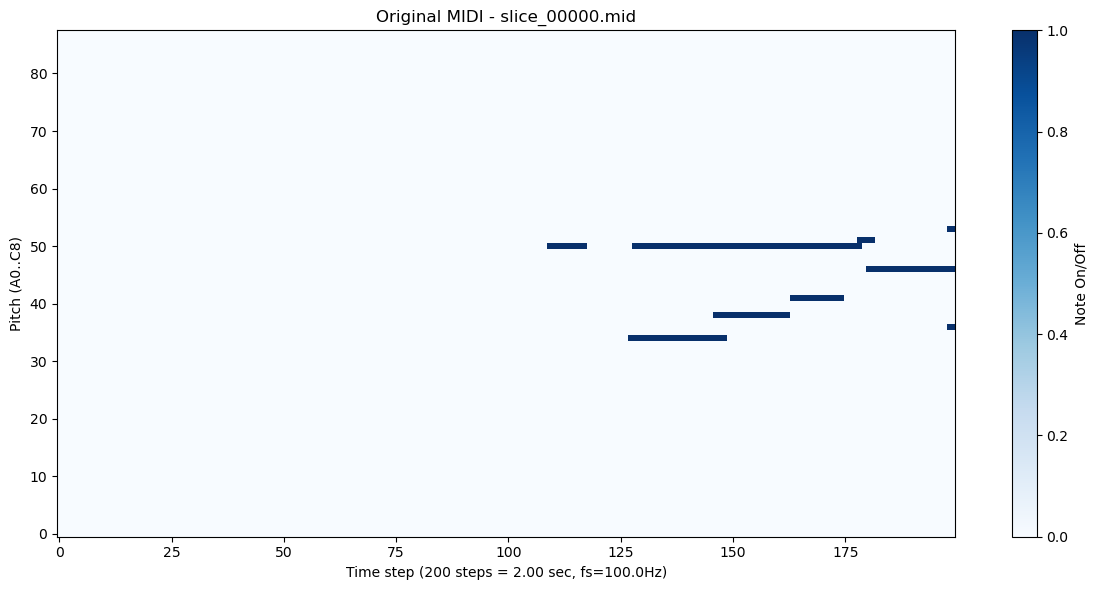

Converting pianoroll: (200, 88) -> 2.00s (fs=100.0Hz)


Generated 9 notes over 2.00 seconds
MIDI saved as: comparison_original.mid
\n2. VAE Reconstruction:


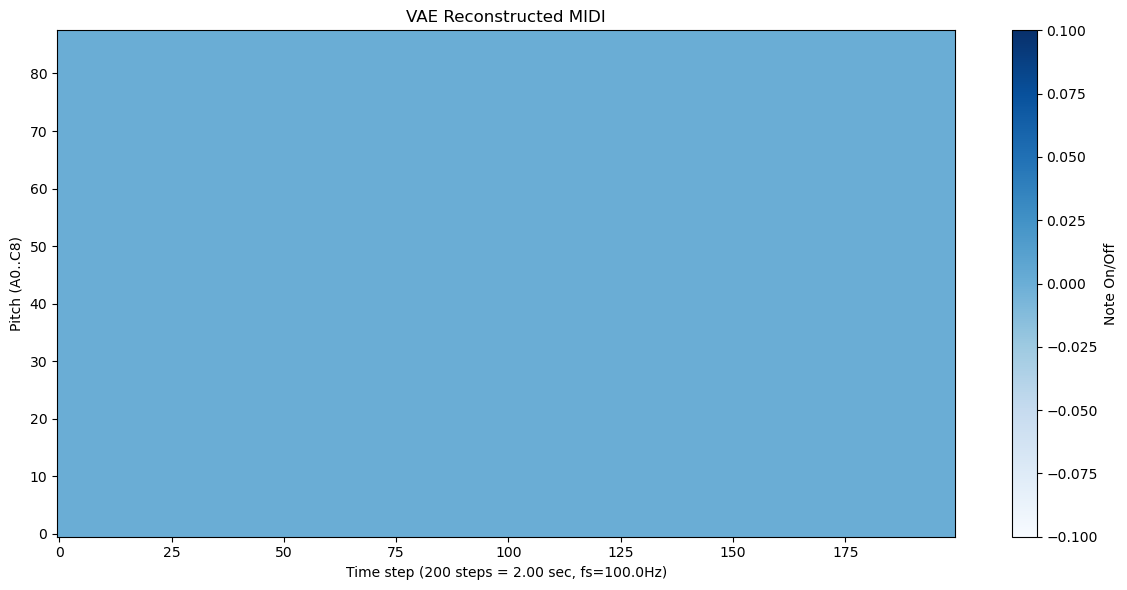

Converting pianoroll: (200, 88) -> 2.00s (fs=100.0Hz)
Error in audio generation: zero-size array to reduction operation maximum which has no identity
Showing pianoroll visualization only.
\nReconstruction Quality Metrics:
MSE (continuous): 0.179594
MSE (binary): 0.007898
Overall accuracy: 0.9921 (17461/17600)
\nLatent Space Analysis:
Mu - mean: -0.0006, std: 0.0360
Logvar - mean: -0.0053, std: 0.0406
Latent dimension: 16
KL Divergence: 0.0160


In [65]:
# Debug and fix the output shape issue
if original_pianoroll is not None and actual_duration is not None:
    print("DEBUGGING OUTPUT SHAPE AND FIXING")
    print("="*50)
    
    # Prepare input tensor
    input_tensor = torch.from_numpy(original_pianoroll).float().unsqueeze(0).to(device)
    batch_size = input_tensor.shape[0]
    sequence_length = input_tensor.shape[1]
    
    # Create proper sentences_length tensor
    sentences_length = torch.tensor([sequence_length], dtype=torch.long)
    
    # Initialize hidden states for encoder
    hidden_encoder = model.init_hidden(batch_size)
    
    model.eval()
    
    with torch.no_grad():
        try:
            output = model(input_tensor, sentences_length, hidden_encoder)
            
            print(f"Model output details:")
            for i, out in enumerate(output):
                if hasattr(out, 'shape'):
                    print(f"  Output {i}: shape {out.shape}")
                else:
                    print(f"  Output {i}: {type(out)} - {out}")
            
            reconstruction = output[0]
            print(f"\\nReconstruction analysis:")
            print(f"Raw shape: {reconstruction.shape}")  # (17600, 2)
            print(f"Expected shape: {original_pianoroll.shape}")  # (200, 88)
            
            # The model seems to output (seq_len * vocab_size, 2) where 2 might be [note_off, note_on]
            # Let's try to reshape it properly
            expected_total = sequence_length * 88  # 200 * 88 = 17600 ✓
            print(f"Expected total elements: {expected_total}")
            print(f"Actual first dimension: {reconstruction.shape[0]}")
            
            if reconstruction.shape[0] == expected_total:
                print("Dimensions match! Reshaping...")
                
                # The output might be logits for [note_off, note_on]
                # Let's take the note_on probability (index 1)
                note_on_logits = reconstruction[:, 1]  # Take the "note on" channel
                
                # Reshape to (seq_len, vocab_size)
                reshaped_logits = note_on_logits.reshape(sequence_length, 88)
                print(f"Reshaped to: {reshaped_logits.shape}")
                
                # Apply sigmoid to get probabilities
                reconstructed_prob = torch.sigmoid(reshaped_logits).cpu().numpy()
                print(f"After sigmoid - min/max: {reconstructed_prob.min():.3f}/{reconstructed_prob.max():.3f}")
                
                # Create binary version
                reconstructed_binary = (reconstructed_prob > 0.5).astype(float)
                
                # Display comparison
                original_notes = np.sum(original_pianoroll > 0.5)
                reconstructed_notes = np.sum(reconstructed_binary > 0.5)
                
                print(f"\\nNote Count Comparison:")
                print(f"Original active notes: {original_notes}")
                print(f"Reconstructed active notes: {reconstructed_notes}")
                
                # Show side-by-side comparison
                print("\\n" + "="*50)
                print("ORIGINAL vs RECONSTRUCTED COMPARISON")
                print("="*50)
                
                # Display original with correct timing
                print("\\n1. Original MIDI:")
                play_and_display_dynamic(original_pianoroll, 
                                       title="Original MIDI - slice_00000.mid", 
                                       temp_midi="comparison_original.mid",
                                       actual_duration=actual_duration)
                
                # Display reconstruction with correct timing  
                print("\\n2. VAE Reconstruction:")
                play_and_display_dynamic(reconstructed_binary, 
                                       title="VAE Reconstructed MIDI", 
                                       temp_midi="comparison_reconstructed.mid",
                                       actual_duration=actual_duration)
                
                # Calculate metrics
                mse_continuous = np.mean((original_pianoroll - reconstructed_prob) ** 2)
                mse_binary = np.mean((original_pianoroll - reconstructed_binary) ** 2) 
                
                # Accuracy metrics
                correct_predictions = np.sum((original_pianoroll > 0.5) == (reconstructed_binary > 0.5))
                total_predictions = original_pianoroll.size
                accuracy = correct_predictions / total_predictions
                
                print(f"\\nReconstruction Quality Metrics:")
                print(f"MSE (continuous): {mse_continuous:.6f}")
                print(f"MSE (binary): {mse_binary:.6f}")
                print(f"Overall accuracy: {accuracy:.4f} ({correct_predictions}/{total_predictions})")
                
                # Get latent representation info
                if len(output) >= 3:
                    mu, logvar = output[1], output[2]
                    print(f"\\nLatent Space Analysis:")
                    print(f"Mu - mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                    print(f"Logvar - mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                    print(f"Latent dimension: {mu.shape[-1]}")
                    
                    # KL divergence (approximate)
                    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                    print(f"KL Divergence: {kl_div.item():.4f}")
                
            else:
                print("Shape mismatch - cannot reshape properly")
                
        except Exception as e:
            print(f"Error: {e}")
            import traceback
            traceback.print_exc()
else:
    print("Original pianoroll or actual_duration not available. Please run the MIDI loading cell first.")

In [71]:
original_pianoroll

# show all unique values in the pianoroll
np.unique(original_pianoroll), np.sum(original_pianoroll > 0.5)

(array([0., 1.]), 139)

In [74]:
reconstruction.shape

torch.Size([17600, 2])

In [76]:
reconstruction[:, 1] > 0.5

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [72]:
reconstructed_binary
np.unique(reconstructed_binary), np.sum(reconstructed_binary > 0.5)

(array([0.]), 0)

# 🔬 Diagnosing Reconstruction Issues

🔬 DIAGNOSTIC ANALYSIS
📊 Raw Reconstruction Analysis:
Raw output shape: torch.Size([17600, 2])
Raw output range: [-1.673969, -0.207641]
Raw output mean: -0.814707
Raw output std: 0.503794
\nChannel 0 (note_off) - range: [-1.673969, -0.901625]
Channel 1 (note_on) - range: [-0.520724, -0.207641]
\n🎯 Probability Analysis:
Sigmoid probabilities - range: [0.372683, 0.448275]
Softmax probabilities - range: [0.594090, 0.812499]
\n📈 Threshold Analysis (Sigmoid):
Threshold | Active Notes | Accuracy
-----------------------------------
    0.1   |     17600    |  0.0079
    0.2   |     17600    |  0.0079
    0.3   |     17600    |  0.0079
    0.4   |     17591    |  0.0084
    0.5   |        0    |  0.9921
    0.6   |        0    |  0.9921
    0.7   |        0    |  0.9921
    0.8   |        0    |  0.9921
    0.9   |        0    |  0.9921
\n🎯 Best threshold: 0.5 (accuracy: 0.9921)
\n📈 Threshold Analysis (Softmax):
Threshold | Active Notes | Accuracy
-----------------------------------
    0.1   |

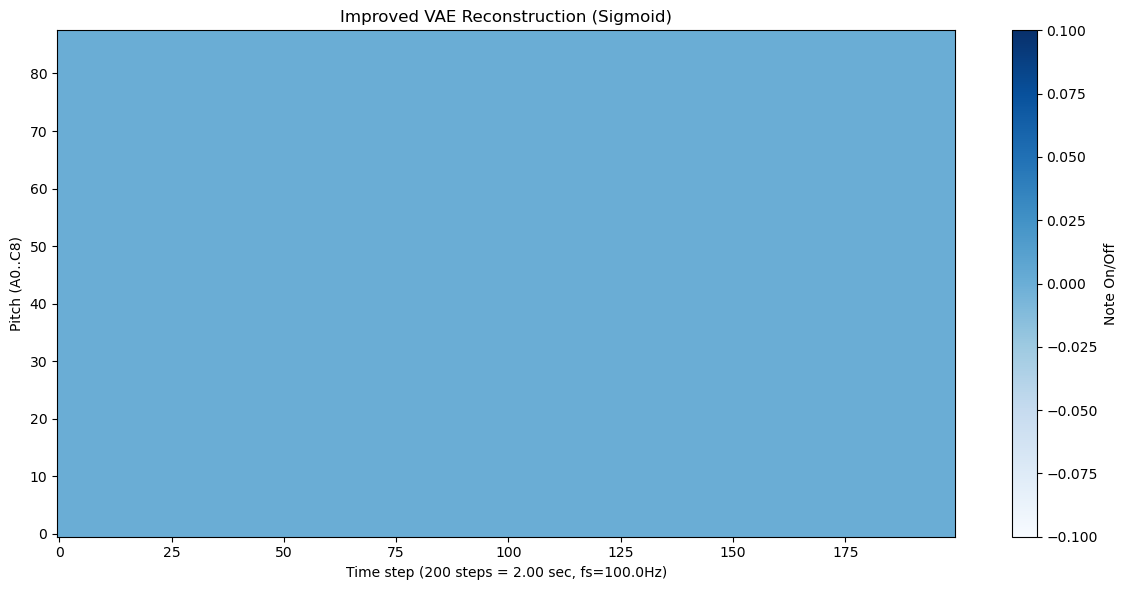

Converting pianoroll: (200, 88) -> 2.00s (fs=100.0Hz)
Error in audio generation: zero-size array to reduction operation maximum which has no identity
Showing pianoroll visualization only.
\n📊 Final Metrics:
Accuracy: 0.9921
MSE: 0.007898
\n🔍 Model Diagnosis:
✅ Model outputs seem reasonable
💡 The threshold adjustment helped!


In [78]:
# Let's investigate what's happening with the model reconstruction
if original_pianoroll is not None and actual_duration is not None:
    print("🔬 DIAGNOSTIC ANALYSIS")
    print("="*60)
    
    # Prepare input
    input_tensor = torch.from_numpy(original_pianoroll).float().unsqueeze(0).to(device)
    sentences_length = torch.tensor([input_tensor.shape[1]], dtype=torch.long)
    hidden_encoder = model.init_hidden(1)
    
    model.eval()
    with torch.no_grad():
        output = model(input_tensor, sentences_length, hidden_encoder)
        reconstruction = output[0]
        
        # Analyze the raw reconstruction output
        print("📊 Raw Reconstruction Analysis:")
        print(f"Raw output shape: {reconstruction.shape}")
        print(f"Raw output range: [{reconstruction.min().item():.6f}, {reconstruction.max().item():.6f}]")
        print(f"Raw output mean: {reconstruction.mean().item():.6f}")
        print(f"Raw output std: {reconstruction.std().item():.6f}")
        
        # Look at both channels
        channel_0 = reconstruction[:, 0]  # note_off logits
        channel_1 = reconstruction[:, 1]  # note_on logits
        
        print(f"\\nChannel 0 (note_off) - range: [{channel_0.min().item():.6f}, {channel_0.max().item():.6f}]")
        print(f"Channel 1 (note_on) - range: [{channel_1.min().item():.6f}, {channel_1.max().item():.6f}]")
        
        # Reshape and analyze
        note_on_logits = channel_1.reshape(200, 88)
        note_off_logits = channel_0.reshape(200, 88)
        
        # Apply softmax to see the probabilities as the model intended
        print(f"\\n🎯 Probability Analysis:")
        
        # Try different activation functions
        sigmoid_probs = torch.sigmoid(note_on_logits).cpu().numpy()
        softmax_probs = torch.softmax(torch.stack([note_off_logits, note_on_logits], dim=-1), dim=-1)[:, :, 1].cpu().numpy()
        
        print(f"Sigmoid probabilities - range: [{sigmoid_probs.min():.6f}, {sigmoid_probs.max():.6f}]")
        print(f"Softmax probabilities - range: [{softmax_probs.min():.6f}, {softmax_probs.max():.6f}]")
        
        # Try different thresholds
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        
        print(f"\\n📈 Threshold Analysis (Sigmoid):")
        print("Threshold | Active Notes | Accuracy")
        print("-" * 35)
        
        best_threshold = 0.5
        best_accuracy = 0
        
        for thresh in thresholds:
            binary_pred = (sigmoid_probs > thresh).astype(float)
            active_notes = np.sum(binary_pred)
            accuracy = np.mean((original_pianoroll > 0.5) == (binary_pred > 0.5))
            
            print(f"   {thresh:4.1f}   |     {active_notes:4.0f}    | {accuracy:7.4f}")
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = thresh
        
        print(f"\\n🎯 Best threshold: {best_threshold} (accuracy: {best_accuracy:.4f})")
        
        # Try with softmax probabilities
        print(f"\\n📈 Threshold Analysis (Softmax):")
        print("Threshold | Active Notes | Accuracy")
        print("-" * 35)
        
        best_threshold_sm = 0.5
        best_accuracy_sm = 0
        
        for thresh in thresholds:
            binary_pred = (softmax_probs > thresh).astype(float)
            active_notes = np.sum(binary_pred)
            accuracy = np.mean((original_pianoroll > 0.5) == (binary_pred > 0.5))
            
            print(f"   {thresh:4.1f}   |     {active_notes:4.0f}    | {accuracy:7.4f}")
            
            if accuracy > best_accuracy_sm:
                best_accuracy_sm = accuracy
                best_threshold_sm = thresh
        
        print(f"\\n🎯 Best softmax threshold: {best_threshold_sm} (accuracy: {best_accuracy_sm:.4f})")
        
        # Generate reconstruction with best threshold
        if best_accuracy_sm > best_accuracy:
            print(f"\\n✨ Using Softmax with threshold {best_threshold_sm:.1f}")
            best_reconstruction = (softmax_probs > best_threshold_sm).astype(float)
            method = "Softmax"
        else:
            print(f"\\n✨ Using Sigmoid with threshold {best_threshold:.1f}")
            best_reconstruction = (sigmoid_probs > best_threshold).astype(float)
            method = "Sigmoid"
        
        # Display the improved reconstruction
        print(f"\\n🎼 Improved Reconstruction Results:")
        print(f"Method: {method}")
        print(f"Original notes: {np.sum(original_pianoroll > 0.5)}")
        print(f"Reconstructed notes: {np.sum(best_reconstruction)}")
        
        # Show the improved reconstruction
        play_and_display_dynamic(best_reconstruction, 
                               title=f"Improved VAE Reconstruction ({method})", 
                               temp_midi="improved_reconstruction.mid",
                               actual_duration=actual_duration)
        
        # Calculate final metrics
        improved_accuracy = np.mean((original_pianoroll > 0.5) == (best_reconstruction > 0.5))
        mse_improved = np.mean((original_pianoroll - best_reconstruction) ** 2)
        
        print(f"\\n📊 Final Metrics:")
        print(f"Accuracy: {improved_accuracy:.4f}")
        print(f"MSE: {mse_improved:.6f}")
        
        # Model diagnosis
        print(f"\\n🔍 Model Diagnosis:")
        if best_threshold < 0.3:
            print("❌ Model outputs are too conservative (low confidence)")
            print("💡 Possible solutions:")
            print("   - Model needs more training")
            print("   - Learning rate might be too low")
            print("   - Model architecture might be too regularized")
        elif best_threshold > 0.7:
            print("❌ Model outputs are too aggressive (high confidence)")
            print("💡 Possible solutions:")
            print("   - Model might be overfitting")
            print("   - Need more regularization during training")
        else:
            print("✅ Model outputs seem reasonable")
            print("💡 The threshold adjustment helped!")

else:
    print("❌ Please run the MIDI loading cell first to get original_pianoroll and actual_duration")